In [1]:
import numpy as np
import pandas as pd
import shap
import torch
import torch.nn as nn
from joblib import load
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Config

In [2]:
target_gauge_id = 2652
predict_next_hours = 12

### Data Loading

In [3]:
data = pd.read_csv(f"../dataset/processed/simple/{target_gauge_id}/{predict_next_hours}.gz")
data.dropna(how="any", inplace=True)

In [4]:
x_data = data.loc[:, (data.columns != "DATE") & (data.columns != "TARGET")]
y_data = data["TARGET"]

In [5]:
x_data

,DISTANCE_0,DISTANCE_1,DISTANCE_2,DISTANCE_3,DISTANCE_4,DISTANCE_5,DISTANCE_6,LEVEL_0_0,LEVEL_0_1,LEVEL_0_2,...,LEVEL_6_62,LEVEL_6_63,LEVEL_6_64,LEVEL_6_65,LEVEL_6_66,LEVEL_6_67,LEVEL_6_68,LEVEL_6_69,LEVEL_6_70,LEVEL_6_71
0,0.0,2.807114,28.111208,57.513182,46.05436,26.261965,45.852162,117.333333,112.166667,120.166667,...,145.666667,145.666667,146.000000,146.000000,146.666667,147.166667,149.833333,149.666667,150.000000,150.000000
1,0.0,2.807114,28.111208,57.513182,46.05436,26.261965,45.852162,112.166667,120.166667,120.000000,...,145.666667,146.000000,146.000000,146.666667,147.166667,149.833333,149.666667,150.000000,150.000000,149.500000
2,0.0,2.807114,28.111208,57.513182,46.05436,26.261965,45.852162,120.166667,120.000000,115.000000,...,146.000000,146.000000,146.666667,147.166667,149.833333,149.666667,150.000000,150.000000,149.500000,149.333333
3,0.0,2.807114,28.111208,57.513182,46.05436,26.261965,45.852162,120.000000,115.000000,116.833333,...,146.000000,146.666667,147.166667,149.833333,149.666667,150.000000,150.000000,149.500000,149.333333,148.833333
4,0.0,2.807114,28.111208,57.513182,46.05436,26.261965,45.852162,115.000000,116.833333,120.000000,...,146.666667,147.166667,149.833333,149.666667,150.000000,150.000000,149.500000,149.333333,148.833333,148.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11575,0.0,2.807114,28.111208,57.513182,46.05436,26.261965,45.852162,131.500000,131.000000,130.166667,...,147.000000,147.666667,147.666667,147.166667,147.000000,147.000000,146.500000,146.166667,146.000000,146.000000
11576,0.0,2.807114,28.111208,57.513182,46.05436,26.261965,45.852162,131.000000,130.166667,131.000000,...,147.666667,147.666667,147.166667,147.000000,147.000000,146.500000,146.166667,146.000000,146.000000,145.833333
11577,0.0,2.807114,28.111208,57.513182,46.05436,26.261965,45.852162,130.166667,131.000000,131.000000,...,147.666667,147.166667,147.000000,147.000000,146.500000,146.166667,146.000000,146.000000,145.833333,145.333333
11578,0.0,2.807114,28.111208,57.513182,46.05436,26.261965,45.852162,131.000000,131.000000,130.333333,...,147.166667,147.000000,147.000000,146.500000,146.166667,146.000000,146.000000,145.833333,145.333333,145.333333


In [6]:
y_data

0        120.000000
1        122.500000
2        121.000000
3        119.166667
4        119.000000
            ...    
11575    114.666667
11576    112.500000
11577    116.833333
11578    119.000000
11579    120.000000
Name: TARGET, Length: 10684, dtype: float64

### Data Processing

In [7]:
# Split datasets into train and test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

# Normalize datasets with scaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [8]:
# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

### Model Setup

In [9]:
# Instantiate the model
model = nn.Sequential(
    nn.Linear(x_train_tensor.shape[1], x_train_tensor.shape[1] * 2),
    nn.ReLU(),
    nn.Linear(x_train_tensor.shape[1] * 2, x_train_tensor.shape[1]),
    nn.ReLU(),
    nn.Linear(x_train_tensor.shape[1], x_train_tensor.shape[1] // 4),
    nn.ReLU(),
    nn.Linear(x_train_tensor.shape[1] // 4, 1),
    nn.Softplus(),
)

### Model Loading

In [10]:
directory = f"../models/simple/{target_gauge_id}"

# Load our scaler
scaler = load(f"{directory}/{predict_next_hours}.bin")

# Load our model
model.load_state_dict(torch.load(f"{directory}/{predict_next_hours}.pth", map_location=torch.device("cpu")))
model.eval()

Sequential(
  (0): Linear(in_features=511, out_features=1022, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1022, out_features=511, bias=True)
  (3): ReLU()
  (4): Linear(in_features=511, out_features=127, bias=True)
  (5): ReLU()
  (6): Linear(in_features=127, out_features=1, bias=True)
  (7): Softplus(beta=1.0, threshold=20.0)
)

### Model Explaining

In [11]:
x_samples_main = x_train_tensor[torch.randint(len(x_train_tensor), (1000,))]
x_samples_values = x_train_tensor[torch.randint(len(x_train_tensor), (500,))]

In [12]:
explainer = shap.DeepExplainer(model, x_samples_main)
shap_values = explainer.shap_values(x_samples_values)
shap_values = np.squeeze(shap_values)

In [13]:
shap_df = pd.DataFrame({
    "mean_abs_shap": np.mean(np.abs(shap_values), axis=0), 
    "stdev_abs_shap": np.std(np.abs(shap_values), axis=0), 
    "name": data.columns[2:],
})
shap_df.sort_values("mean_abs_shap", ascending=False)

,mean_abs_shap,stdev_abs_shap,name
510,10.618591,11.712153,LEVEL_6_71
438,10.482145,12.753121,LEVEL_5_71
366,6.650755,7.174834,LEVEL_4_71
294,6.578882,5.947925,LEVEL_3_71
150,5.567896,6.246068,LEVEL_1_71
...,...,...,...
5,0.000000,0.000000,DISTANCE_5
4,0.000000,0.000000,DISTANCE_4
3,0.000000,0.000000,DISTANCE_3
2,0.000000,0.000000,DISTANCE_2


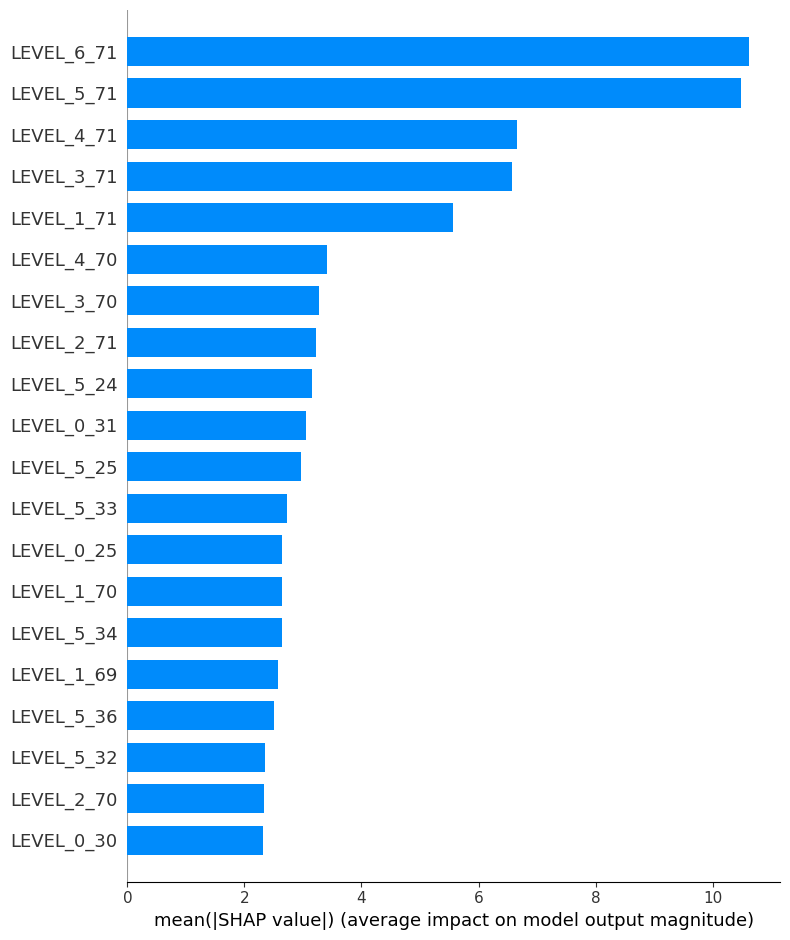

In [14]:
shap.summary_plot(shap_values, features=x_samples_values, feature_names=data.columns[2:], plot_type="bar")

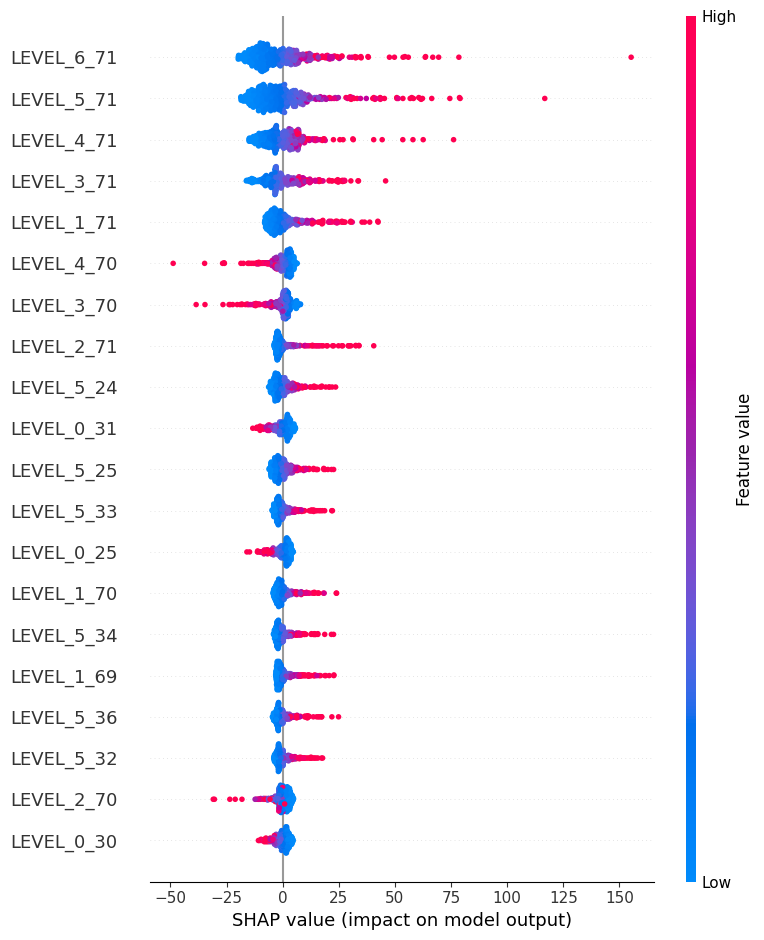

In [15]:
shap.summary_plot(shap_values, features=x_samples_values, feature_names=data.columns[2:], plot_type="dot")

### Model Evaluation

In [16]:
with torch.no_grad():
    y_pred = pd.DataFrame(model(x_test_tensor).numpy(), columns=["PREDICTION"])
    results = pd.merge(y_test.reset_index(drop=True), y_pred, left_index=True, right_index=True)

In [17]:
results["DIFF"] = (results["TARGET"] - results["PREDICTION"])**2

In [18]:
results

,TARGET,PREDICTION,DIFF
0,130.000000,128.123932,3.519632
1,142.000000,142.179504,0.032222
2,179.833333,183.598938,14.179778
3,246.833333,245.572327,1.590138
4,121.000000,125.745331,22.518165
...,...,...,...
3201,117.500000,120.035210,6.427288
3202,134.000000,132.576508,2.026331
3203,129.333333,127.719719,2.603751
3204,130.000000,135.404404,29.207579


In [19]:
print("MSE: %.2f" % results["DIFF"].mean())
print("RMSE: %.2f" % np.sqrt(results["DIFF"].mean()))

MSE: 51.59
RMSE: 7.18
